# Annotating the PMBC3K dataset using PCA and scllm

## Summary

In this code, we analyze single-cell RNA sequencing data from the PBMC dataset using various computational techniques. We first perform PCA to reduce dimensionality and then use a language model to annotate the principal components with relevant biological factors and genetic pathways. We visualize these annotations through strip plots and embeddings. Next, we apply the Leiden clustering algorithm to identify distinct cell populations and annotate these clusters using the language model again. Finally, we visualize the clusters on a UMAP plot and generate a heatmap to display the expression of key genes across the annotated clusters. This workflow integrates data processing, machine learning, and visualization to enhance our understanding of cellular heterogeneity.

First, we load our environment variables using `load_dotenv()`, which allows us to access sensitive information like our OpenAI API key without hardcoding it. Then, we import necessary libraries: `scllm` for data annotation, `scanpy` for single-cell analysis, `pandas` for data manipulation, and `matplotlib.pyplot` for plotting. 

Next, we set up the OpenAI model with `ChatOpenAI`, specifying the model type and temperature for response variability. This model will help us annotate our PBMC dataset later in the script. The rest of the code focuses on processing the PBMC data, performing PCA, and generating visualizations, but these initial lines are crucial for setting up our environment and tools for the analysis.

In [1]:
# Enter your API key for ChatGPT
# import os
# os.environ["OPENAI_API_KEY"] = "Enter your API key here."
# Or alternatively save your OPENAI key in a .env file and load it via dotenv
from dotenv import load_dotenv
load_dotenv()
import scllm as sl
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI

## Setup

In this section, we set up the language model that will help us annotate our PBMC dataset. We specify the model we want to use, `gpt-4o-mini`, and create an instance of `ChatOpenAI` with a temperature of 0.0, which means we want deterministic outputs. This is crucial for consistent annotations. By using this model, we can leverage its capabilities to interpret and annotate our data based on the PCA results and other analyses we perform later in the script. This setup is essential for the subsequent steps where we call `sl.tl.annotate_factor` and `sl.tl.annotate_cluster`, allowing us to enrich our dataset with meaningful biological insights.

In [ ]:
openai_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=openai_model)

In these lines, we load the PBMC dataset using `sc.datasets.pbmc3k_processed()`, which gives us a pre-processed single-cell RNA-seq dataset of peripheral blood mononuclear cells. Then, we perform Principal Component Analysis (PCA) on this dataset with `sc.pp.pca(pbmc, n_comps=20)`, reducing the dimensionality to 20 principal components. This step is crucial because it helps us capture the most important variations in the data, making it easier to visualize and analyze later on. Essentially, we’re setting the stage for the subsequent annotation and visualization tasks in the script.

In [ ]:
pbmc = sc.datasets.pbmc3k_processed()
sc.pp.pca(pbmc, n_comps=20)

## Annotating PCA factors

In this section, we use the `annotate_factor` function from the `scllm` package to annotate our PCA factors. This function grabs the genes with the largest absolute weights from our PCA results and queries a large language model (LLM) to predict the most likely cell type associated with those genes. Since LLMs provide probabilistic outputs, we sample the results `num_samples` times and select the most frequent answer as our final annotation. 

By setting `top_genes=40`, we focus on the top 40 genes contributing to each PCA factor, and we store the results in `pca_annotation`. This helps us understand the biological significance of the PCA dimensions in our PBMC dataset, making it easier to interpret the underlying cellular heterogeneity.

In [ ]:
sl.tl.annotate_factor(
    pbmc, 
    varm_key='PCs', 
    llm=llm, 
    top_genes=40, 
    key_added='pca_annotation', 
    num_samples=5
)

In the line `pbmc.uns['pca_annotation']['mapping']`, we access the results of our PCA annotation, which stores the mapping of PCA components to their corresponding biological factors. Earlier in the script, we used `sl.tl.annotate_factor` to annotate the PCA results based on the top genes, and this line lets us see that mapping. We also create visualizations with `sl.pl.factor_stripplot` and `sl.pl.factor_embedding` to explore how these annotations relate to the PCA components. Later, we annotate clusters identified by the Leiden algorithm with `sl.tl.annotate_cluster`, which helps us understand the biological significance of those clusters. Finally, we visualize the cluster annotations alongside the original clustering to see how well they align.

In [ ]:
pbmc.uns['pca_annotation']['mapping']

{'0+': 'Monocyte/Macrophage',
 '0-': 'Cytotoxic T cell',
 '1+': 'Cytotoxic T cell',
 '1-': 'B cell',
 '10+': 'Natural Killer Cell',
 '10-': 'Natural Killer Cell',
 '11+': 'Macrophage',
 '11-': 'Dendritic Cell',
 '12+': 'Plasma Cell',
 '12-': 'Photoreceptor',
 '13+': 'B cell',
 '13-': 'T follicular helper cell',
 '14+': 'B cells',
 '14-': 'Natural Killer Cell',
 '15+': 'Natural Killer (NK) Cell',
 '15-': 'Cardiomyocyte',
 '16+': 'B cell',
 '16-': 'B cell',
 '17+': 'B cell',
 '17-': 'T cell',
 '18+': 'B cell',
 '18-': 'B cell',
 '19+': 'Endothelial Cell',
 '19-': 'Natural Killer Cell',
 '2+': 'Platelet',
 '2-': 'B cell',
 '3+': 'B cell',
 '3-': 'T cell',
 '4+': 'Monocyte/Macrophage',
 '4-': 'Dendritic Cell',
 '5+': 'Cytotoxic T cell',
 '5-': 'Natural Killer Cell',
 '6+': 'Natural Killer (NK) Cell',
 '6-': 'T helper 1 (Th1) cell',
 '7+': 'Dendritic Cell',
 '7-': 'Natural Killer (NK) Cell',
 '8+': 'Dendritic Cell',
 '8-': 'Activated T cell',
 '9+': 'Interferon-stimulated macrophages',
 '9-

In this part of the script, we create a strip plot to visualize the PCA annotations of our PBMC dataset. The `plt.figure(figsize=(6, 12))` line sets up a figure with a specific size for our plot. Then, we use `ax = plt.gca()` to get the current axes, which allows us to customize our plot further.

The `sl.pl.factor_stripplot` function is where the magic happens. We pass in our PBMC data, specify that we want to use the PCA coordinates (`obsm_key='X_pca'`), and indicate that we want to visualize the PCA annotations (`annotation_key='pca_annotation'`). The `size` and `jitter` parameters help adjust the appearance of the points in the plot, making it easier to see overlapping data. Finally, we set the x-axis limits with `ax.set_xlim([-20, 30])` to focus on the relevant range of our PCA results.

(-20.0, 30.0)

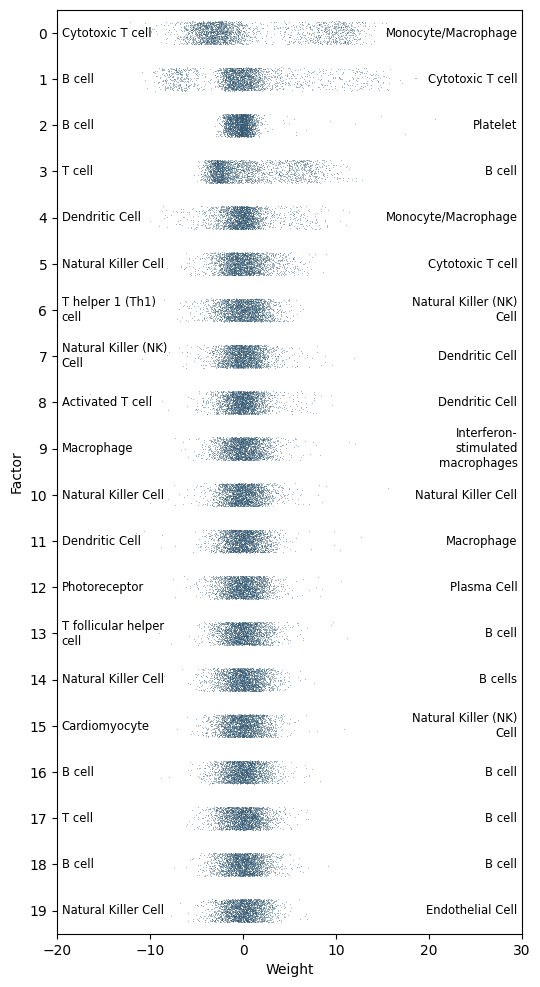

In [ ]:
plt.figure(figsize=(6, 12))
ax = plt.gca()
sl.pl.factor_stripplot(
    pbmc,
    obsm_key='X_pca',
    annotation_key='pca_annotation',
    size=.4,
    jitter=.25,
    ax=ax
)
ax.set_xlim([-20, 30])

In this part of the script, we project the PCA factor values onto a UMAP representation. This is useful because UMAP helps visualize high-dimensional data in a lower-dimensional space, making it easier to identify clusters and patterns. 

The line `_ = sl.pl.factor_embedding(...)` takes the PCA factors (like '0', '1', '2', etc.) and maps them onto the UMAP coordinates stored in `X_umap`. We specify the `annotation_key` as 'pca_annotation' to label the points based on the PCA annotations we generated earlier. The `ncols=2` argument organizes the output into two columns for better visualization. 

By doing this, we can see how the PCA factors relate to the overall structure of the data, helping us understand the underlying biological significance of the clusters.

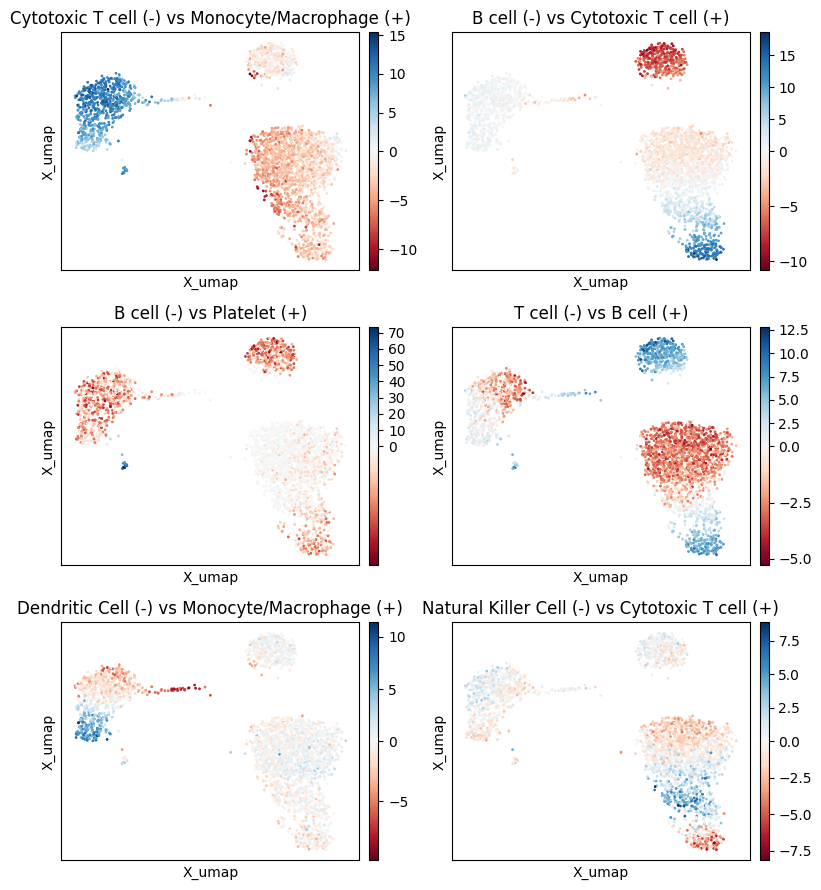

In [ ]:
_ = sl.pl.factor_embedding(
    pbmc, 
    factors=['0', '1', '2', '3', '4', '5'],
    obsm_key='X_pca', 
    basis='X_umap', 
    annotation_key='pca_annotation',
    ncols=2
    )
plt.tight_layout()

### Annotating factors with other terms

In this part of the script, we use the `sl.tl.annotate_factor` function to annotate our PCA results with a different focus—specifically, genetic pathways. By setting the `term` argument to 'genetic pathway', we can modify the predictions to reflect this new context. 

We specify `top_genes=30` to limit the annotation to the top 30 genes contributing to the PCA components. The `key_added='gene_pathway'` argument tells the function to store the results under this new key in the `pbmc` object. This allows us to easily access and visualize the genetic pathway annotations later on. Overall, this step enhances our understanding of the biological significance behind the PCA factors.

In [ ]:
sl.tl.annotate_factor(
    pbmc, 
    varm_key='PCs', 
    llm=llm, 
    top_genes=30, 
    key_added='gene_pathway', 
    term='genetic pathway', 
    num_samples=5
)

In this part of the script, we create a strip plot to visualize the annotations related to genetic pathways from our PBMC dataset. First, we set up the figure size and get the current axes with `plt.gca()`. Then, we call `sl.pl.factor_stripplot()` to plot the PCA coordinates (`obsm_key='X_pca'`) against the `gene_pathway` annotations. We adjust the size of the points and add some jitter for better visibility. Finally, we set the x-axis limits to focus on the relevant range of PCA values. This helps us see how different genetic pathways are distributed across the PCA space, giving insights into the underlying biology of our data.

(-20.0, 30.0)

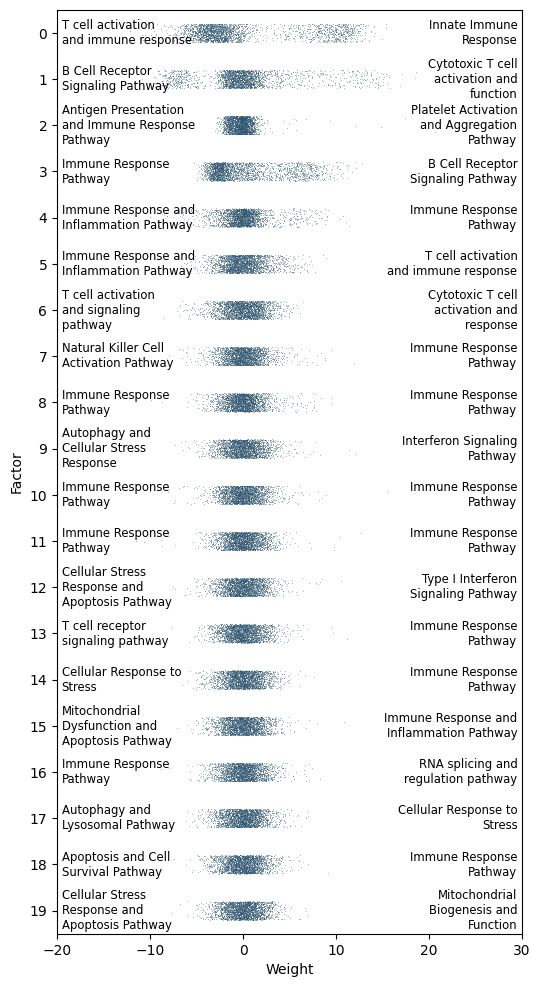

In [ ]:
plt.figure(figsize=(6, 12))
ax = plt.gca()
sl.pl.factor_stripplot(
    pbmc,
    obsm_key='X_pca',
    annotation_key='gene_pathway',
    size=.4,
    jitter=.2,
    ax=ax,
)
ax.set_xlim([-20, 30])

In this part of the script, we’re using the Leiden algorithm to cluster our PBMC dataset. The line `sc.tl.leiden(pbmc, flavor="igraph", n_iterations=2)` tells Scanpy to apply the Leiden clustering method, which is great for identifying clusters in single-cell data. The `flavor="igraph"` option specifies that we want to use the igraph library for the clustering process, which is efficient and robust. The `n_iterations=2` parameter indicates that the algorithm will run for two iterations to refine the clusters. This step is crucial because it helps us group similar cells together based on their gene expression profiles, setting the stage for further analysis and annotation of these clusters.

In [21]:
sc.tl.leiden(pbmc, flavor="igraph", n_iterations=2)

In this part of the script, we use `sc.pl.umap(pbmc, color='leiden')` to visualize the UMAP (Uniform Manifold Approximation and Projection) representation of our PBMC dataset, coloring the points based on the 'leiden' clustering results. This helps us see how the cells group together based on their similarities after we've performed clustering. The 'leiden' key contains the cluster assignments for each cell, which we generated earlier in the script. By plotting this, we can quickly assess the effectiveness of our clustering and identify distinct cell populations in the dataset. It's a crucial step for understanding the structure of our data visually.

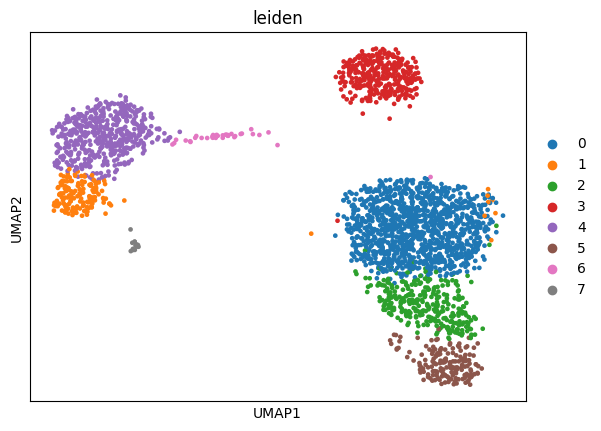

In [22]:
sc.pl.umap(pbmc, color='leiden')

In this part of the script, we’re using the `annotate_cluster` function from the `scllm` package to add meaningful annotations to the clusters identified in our PBMC dataset. We specify `cluster_key='leiden'`, which tells the function to use the Leiden clustering results we generated earlier. The `llm=llm` argument passes our language model for generating annotations. By setting `use_raw=True`, we ensure that the raw counts are used for annotation, which can provide more accurate insights. We also specify `top_genes=50` to focus on the most significant genes in each cluster, and `num_samples=5` to generate a few different annotation samples for each cluster. This helps us understand the biological significance of the clusters we identified.

In [ ]:
sl.tl.annotate_cluster(
    pbmc, 
    cluster_key='leiden', 
    llm=llm, 
    use_raw=True, 
    top_genes=50, 
    num_samples=5
)

/Users/harald/Documents/opt/scllm/src/scllm/tl/cluster_annotation.py:40: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  flattened=lambda df: df["union"].apply(


In this part of the script, we’re visualizing the results of our clustering analysis on the PBMC dataset. The `sc.pl.umap` function generates a UMAP plot, which is a great way to visualize high-dimensional data in two dimensions. We’re coloring the points based on two different annotations: `cluster_annotation` and `louvain`. This helps us see how our clusters (from the Leiden algorithm we ran earlier) relate to the Louvain clustering method. By setting `ncols=1`, we ensure that both annotations are displayed in a single column, making it easier to compare the two clustering results side by side. This visualization gives us insights into the structure of our data and how well our annotations align with the clusters.

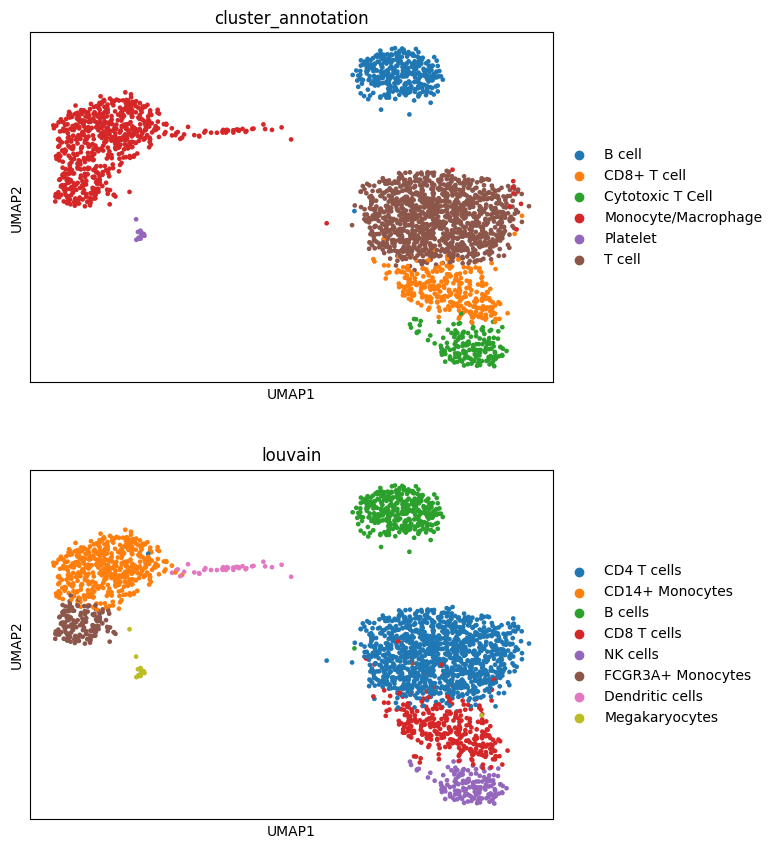

In [26]:
sc.pl.umap(pbmc, color=['cluster_annotation', 'louvain'], ncols=1)

In this part of the script, we use the `sc.pl.heatmap` function to visualize the expression of genes that are relevant to the clusters we've annotated. Specifically, `pbmc.uns['cluster_annotation']['var_names']` retrieves the gene names that the `annotate_cluster` function identified as significant for each cluster. This helps us see which genes are driving the characteristics of the different clusters we found using the Leiden algorithm. By grouping the heatmap by `cluster_annotation`, we can easily compare gene expression patterns across clusters, giving us insights into their biological significance. This visualization is crucial for understanding the underlying biology of our PBMC dataset.

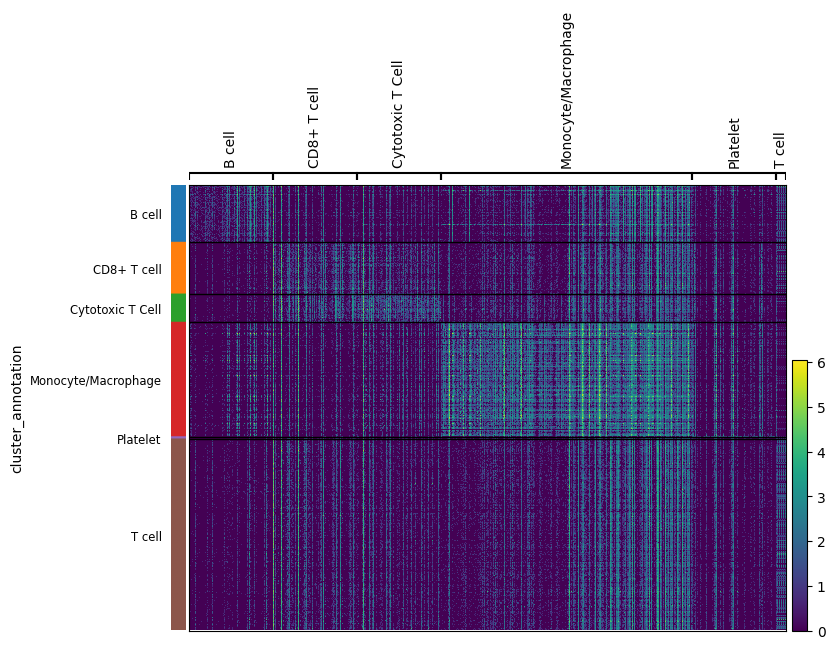

In [ ]:
sc.pl.heatmap(
    pbmc, 
    var_names=pbmc.uns['cluster_annotation']['var_names'], 
    groupby='cluster_annotation'
)

We start by loading the PBMC dataset and performing PCA to reduce dimensionality. Then, we use the `scllm` package to annotate the PCA results with the `annotate_factor` function, which leverages a language model to identify the top genes associated with each principal component. We visualize these annotations with a strip plot. Next, we annotate the dataset with genetic pathways, again using the same function, and plot the results. After that, we apply the Leiden clustering algorithm to identify cell clusters and visualize them on a UMAP plot. Finally, we annotate these clusters and create a heatmap to show the expression of the top genes in each cluster, providing insights into the cellular composition of the PBMC dataset.